In [1]:
import os
import pickle
import random
import numpy as np
import pandas as pd
import tkinter as tk
import tensorflow as tf
from pathlib import Path
from tkinter import messagebox
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
from collections import defaultdict
from tensorflow.keras.models import Sequential
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [13]:
def train_model(data_path: str = './data', epochs: int = 100):
    # Define the paths
    train_dir = f'{data_path}/train'
    valid_dir = f'{data_path}/valid'
    test_dir = f'{data_path}/test'
    
    # Load the CSV file
    dataset_csv = pd.read_csv(f'{data_path}/cards.csv')

    # Create ImageDataGenerator for loading and augmenting images
    train_datagen = ImageDataGenerator(rescale=1./255)
    valid_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )
    
    valid_generator = valid_datagen.flow_from_directory(
        valid_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )
    
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    model_path = f'./models/{epochs}_model.h5'
    if Path(model_path).exists():
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(53, activation='softmax')  # 53 classes for 53 cards
        ])
        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        model.load_weights(model_path)  # Load your trained model weights
        return model
    else:
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(53, activation='softmax')  # 53 classes for 53 cards
        ])
        
        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        
        # Train the model
        history = model.fit(
            train_generator,
            epochs=epochs,
            validation_data=valid_generator
        )
    
        # Evaluate the model
        loss, accuracy = model.evaluate(test_generator)
        print(f'Test accuracy: {accuracy}')
    
        model.save(model_path)

    return model

In [14]:
model = train_model(epochs=5)

Found 7624 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


In [4]:
class CardCounter:
    high_cards = ('ten', 'jack', 'queen', 'king', 'ace')
    low_cards = ('two', 'three', 'four', 'five', 'six')

    def __init__(self, model, n_decks: int = 8):
        self.model = model
        self.n_decks = n_decks
        self.total_cards = 52 * n_decks
        self._count = 0
        self._remaining_cards = {
            'total': self.total_cards, 
            'high': int(round(self.total_cards * 5 / 13)), 
            'low': int(round(self.total_cards * 5 / 13)),
            'neutral': int(round(self.total_cards * 3 / 13))
        }
        
        self.test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
            './data/test',
            target_size=(224, 224),
            batch_size=32,
            class_mode='categorical'
        )
        
        self.card_counts = {label: 0 for label in self.test_generator.class_indices.keys()}

    @property
    def count(self):
        return self._count

    @count.setter
    def count(self, count: int):
        self._count = count

    @property
    def remaining_cards(self):
        return self._remaining_cards

    @remaining_cards.setter
    def remaining_cards(self, remaining_cards: int):
        self._remaining_cards = remaining_cards

    def reset_deck(self):
        self.total_cards = 52 * self.n_decks
        
        self.remaining_cards = {
            'total': self.total_cards, 
            'high': int(round(self.total_cards * 5 / 13)), 
            'low': int(round(self.total_cards * 5 / 13)),
            'neutral': int(round(self.total_cards * 3 / 13))
        }
        
        self.count = 0
        self.card_counts = {label: 0 for label in self.test_generator.class_indices.keys()}
    
    def classify_card(self, image):
        image = tf.image.resize(image, (224, 224))
        image = tf.expand_dims(image, 0)  # Add batch dimension
        predictions = self.model.predict(image)
        class_index = tf.argmax(predictions[0]).numpy()
        class_label = list(self.test_generator.class_indices.keys())[class_index]
        return class_label
    
    def count_cards(self, images):
        high_cards = 0
        low_cards = 0
        neutral_cards = 0
        card_labels = []
        for image in images:
            card_label = self.classify_card(image=image)
            rank = card_label.split()[0]
            suit = card_label.split()[-1]
            card_labels.append((rank, suit))
            self.card_counts[card_label] += 1
            
            if card_label.split()[0] in self.high_cards:
                self.count -= 1
                high_cards += 1
            elif card_label.split()[0] in self.low_cards:
                self.count += 1
                low_cards += 1
            else:
                neutral_cards += 1
    
        # Calculate remaining cards
        self.remaining_cards['total'] -= len(images)
        self.remaining_cards['high'] -= high_cards
        self.remaining_cards['low'] -= low_cards
        self.remaining_cards['neutral'] -= neutral_cards
    
        prob_high = self.remaining_cards['high'] / self.remaining_cards['total'] if self.remaining_cards['total'] > 0 else 0
        prob_low = self.remaining_cards['low'] / self.remaining_cards['total'] if self.remaining_cards['total'] > 0 else 0
        prob_neutral = self.remaining_cards['neutral'] / self.remaining_cards['total'] if self.remaining_cards['total'] > 0 else 0

        return prob_high, prob_low, prob_neutral, card_labels

In [15]:
image_paths = [r'.\data\test\ace of clubs\1.jpg', r'.\data\test\nine of clubs\1.jpg', 
               r'.\data\test\six of clubs\1.jpg', r'.\data\test\king of hearts\1.jpg']

images = [tf.io.read_file(image_path) for image_path in image_paths]
images = [tf.image.decode_jpeg(image, channels=3) for image in images]

In [17]:
card_counter = CardCounter(model=model)
prob_high, prob_low, prob_neutral, card_labels = card_counter.count_cards(images=images)
print(f'Predicted Cards: {card_labels}')
print(f'Probability of next card being +1 count: {prob_low:.2f}')
print(f'Probability of next card being -1 count: {prob_high:.2f}')
print(f'Probability of next card being 0 count: {prob_neutral:.2f}')

Found 265 images belonging to 53 classes.
1/1 [==============================] - 0s 44ms/step
Predicted Cards: [('ten', 'clubs'), ('eight', 'clubs'), ('jack', 'spades'), ('queen', 'hearts')]
Probability of next card being +1 count: 0.39
Probability of next card being -1 count: 0.38
Probability of next card being 0 count: 0.23


In [20]:
class BlackjackGame:
    def __init__(self, root, bankroll: int, model_path: str):
        self.root = root
        self.root.title("Blackjack Game")

        self.suits = ('hearts', 'diamonds', 'clubs', 'spades')
        self.ranks = {
            'two': 2, 
            'three': 3, 
            'four': 4, 
            'five': 5, 
            'six': 6, 
            'seven': 7, 
            'eight': 8, 
            'nine': 9, 
            'ten': 10, 
            'jack': 10, 
            'queen': 10, 
            'king': 10, 
            'ace': 11
        }
        
        self.model_path = model_path

        # Load the trained model
        self.model = self.load_model()

        # Initialize game variables
        self.card_counter = CardCounter(model=model)
        self.deck = self.create_deck()
        self.player_hand = []
        self.dealer_hand = []
        self.card_images = []
        self.wins = 0
        self.losses = 0
        self.draws = 0
        self.bankroll = bankroll

        # Create GUI elements
        self.create_widgets()

    def load_model(self):
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(53, activation='softmax')  # 53 classes for 53 cards
        ])
        
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        model.load_weights(self.model_path)  # Load your trained model weights
        return model

    def create_deck(self):
        deck = [(rank, suit) for rank in self.ranks.keys() for suit in self.suits] * self.card_counter.n_decks
        random.shuffle(deck)
        return deck

    def create_widgets(self):
        self.player_label = tk.Label(self.root, text="Player's Hand")
        self.player_label.pack()
        self.player_frame = tk.Frame(self.root)
        self.player_frame.pack()

        self.dealer_label = tk.Label(self.root, text="Dealer's Hand")
        self.dealer_label.pack()
        self.dealer_frame = tk.Frame(self.root)
        self.dealer_frame.pack()

        self.hit_button = tk.Button(self.root, text="Hit", command=self.hit)
        self.hit_button.pack(side=tk.LEFT)
        self.stand_button = tk.Button(self.root, text="Stand", command=self.stand)
        self.stand_button.pack(side=tk.LEFT)
        self.reset_button = tk.Button(self.root, text="Reset", command=self.reset_game)
        self.reset_button.pack(side=tk.LEFT)

        self.prob_label = tk.Label(self.root, text="Probabilities - High: 0.00, Low: 0.00, Neutral: 0.00")
        self.prob_label.pack()

        self.game_label = tk.Label(self.root, text="Game 1: Wins - 0, Losses - 0, Draws - 0 -- Cards Left = 416")
        self.game_label.pack()

        self.wallet_label = tk.Label(self.root, text=f"Bankroll: ${self.bankroll}")
        self.wallet_label.pack()

    def start_game(self):
        self.deal_card_to_player()
        self.deal_card_to_dealer()
        self.deal_card_to_player()
        self.deal_card_to_dealer()
        
        player_value = self.calculate_hand_value(self.player_hand)
        dealer_value = self.calculate_hand_value(self.dealer_hand)
        
        if player_value == 21 and dealer_value == 21:
            self.draws += 1
            self.update_game_label(0)
            messagebox.showinfo("Blackjack", "Draw!")
            self.reset_game()
        elif player_value == 21:
            self.wins += 1
            self.update_game_label(100)
            messagebox.showinfo("Blackjack", "Player wins!")
            self.reset_game()
        elif dealer_value == 21:
            self.losses += 1
            self.update_game_label(-100)
            messagebox.showinfo("Blackjack", "Dealer wins!")
            self.reset_game()
        
    def update_probabilities_label(self, prob_high, prob_low, prob_neutral):
        self.prob_label.config(text=f'Probabilities - High: {prob_high:.2f}, Low: {prob_low:.2f}, Neutral: {prob_neutral:.2f}')
    
    def update_game_label(self, rewards: int):
        self.game_label.config(text=f'Game {self.wins + self.losses + self.draws}: Wins - {self.wins}, Losses - {self.losses}, Draws - {self.draws} -- Cards Left = {self.card_counter.remaining_cards["total"]}')
        self.bankroll += rewards
        self.wallet_label.config(text=f"Bankroll: ${self.bankroll}")
    
    def deal_card_to_player(self):
        card = self.deck.pop()
        self.card_counter.total_cards -= 1
        if self.card_counter.total_cards == 0:
            self.deck = self.create_deck()
            self.card_counter.reset_deck()
            
        self.player_hand.append(card)
        img_path = f'./data/test/{card[0]} of {card[1]}/1.jpg'
        
        # Debugging: Check if the image path exists
        if not os.path.exists(img_path):
            print(f"Image path does not exist: {img_path}")
            return
        
        images = [tf.image.decode_jpeg(tf.io.read_file(img_path), channels=3)]
        prob_high, prob_low, prob_neutral, predicted_cards = self.card_counter.count_cards(images=images)

        try:
            img = Image.open(img_path)
            img = img.resize((100, 150), Image.LANCZOS)
            photo = ImageTk.PhotoImage(img)
            self.card_images.append(photo)  # Keep a reference to the image
            frame = tk.Frame(self.player_frame)
            frame.pack(side=tk.LEFT)
            label = tk.Label(frame, image=photo)
            label.image = photo  # Ensure reference is kept by the label
            label.pack()
            tk.Label(frame, text=f'{card[0]} of {card[1]}').pack()
        except Exception as e:
            print(f"Failed to load image {img_path}: {e}")

        # Update probabilities label
        self.update_probabilities_label(prob_high, prob_low, prob_neutral)
    
    def deal_card_to_dealer(self):
        real_card = self.deck.pop()
        self.card_counter.total_cards -= 1
        if self.card_counter.total_cards == 0:
            self.deck = self.create_deck()
            self.card_counter.reset_deck()
            
        real_img_path = f'./data/test/{real_card[0]} of {real_card[1]}/1.jpg'
        
        # Debugging: Check if the image path exists
        if not os.path.exists(real_img_path):
            print(f"Image path does not exist: {real_img_path}")
            return

        images = [tf.image.decode_jpeg(tf.io.read_file(real_img_path), channels=3)]
        prob_high, prob_low, prob_neutral, predicted_cards = self.card_counter.count_cards(images=images)
        predicted_card = predicted_cards[0]
        predicted_img_path = f'./data/test/{predicted_card[0]} of {predicted_card[1]}/1.jpg'

        if not os.path.exists(predicted_img_path):
            print(f"Image path does not exist: {predicted_img_path}")
            return
        
        self.dealer_hand.append(real_card)

        try:
            real_img = Image.open(real_img_path)
            real_img = real_img.resize((100, 150), Image.LANCZOS)
            real_photo = ImageTk.PhotoImage(real_img)
            self.card_images.append(real_photo)
            frame = tk.Frame(self.dealer_frame)
            frame.pack(side=tk.LEFT)
            real_label = tk.Label(frame, image=real_photo)
            real_label.image = real_photo  # Ensure reference is kept by the label
            real_label.pack()
            tk.Label(frame, text=f'Actual: {real_card[0]} of {real_card[1]}\nPredicted: {predicted_card[0]} of {predicted_card[1]}').pack()
        except Exception as e:
            print(f"Failed to load image {real_img_path} or {predicted_img_path}: {e}")

        # Update probabilities label
        self.update_probabilities_label(prob_high, prob_low, prob_neutral)

    def hit(self):
        self.deal_card_to_player()
        player_value = self.calculate_hand_value(self.player_hand)
        if player_value > 21:
            self.losses += 1
            self.update_game_label(-100)
            messagebox.showinfo("Blackjack", "Player busts! Dealer wins!")
            self.reset_game()

        if player_value == 21:
            self.wins += 1
            self.update_game_label(100)
            messagebox.showinfo("Blackjack", "Player wins!")
            self.reset_game()

    def stand(self):
        player_value = self.calculate_hand_value(self.player_hand)
        if player_value == 21:
            self.wins += 1
            self.update_game_label(100)
            messagebox.showinfo("Blackjack", "Player wins!")
            self.reset_game()
            
        while self.calculate_hand_value(self.dealer_hand) < 17:
            self.deal_card_to_dealer()
            
        dealer_value = self.calculate_hand_value(self.dealer_hand)
        
        if dealer_value > 21 or player_value > dealer_value:
            self.wins += 1
            self.update_game_label(100)
            messagebox.showinfo("Blackjack", "Player wins!")
            self.reset_game()
        else:
            self.losses += 1
            self.update_game_label(-100)
            messagebox.showinfo("Blackjack", "Dealer wins!")
            self.reset_game()

    def reset_game(self):
        for widget in self.player_frame.winfo_children():
            widget.destroy()
            
        for widget in self.dealer_frame.winfo_children():
            widget.destroy()
            
        self.player_hand = []
        self.dealer_hand = []
        self.start_game()
        self.enable_buttons()

    def calculate_hand_value(self, hand):
        value = 0
        ace_count = 0
        for card in hand:
            rank = card[0]
            value += self.ranks[rank]
            
            if rank == 'ace':
                ace_count += 1
                
        while value > 21 and ace_count:
            value -= 10
            ace_count -= 1
            
        return value

    def disable_buttons(self):
        self.hit_button.config(state=tk.DISABLED)
        self.stand_button.config(state=tk.DISABLED)

    def enable_buttons(self):
        self.hit_button.config(state=tk.NORMAL)
        self.stand_button.config(state=tk.NORMAL)

In [21]:
# Create the main window
root = tk.Tk()
game = BlackjackGame(root, 18000, './models/5_model.h5')
game.start_game()
root.mainloop()

Found 265 images belonging to 53 classes.
1/1 [==============================] - 0s 50ms/step


### Now, use the prediction from the CNN model to feed the RL model information that will use slightly mislead it from the truth and the RL will have to learn to play blackjack by relying computer vision

In [22]:
class BlackjackEnvironment:
    def __init__(self, cnn_model, n_decks):
        self.player_hand = []
        self.dealer_hand = []
        self.player_hand_real = []
        self.dealer_hand_real = []
        self.wins = 0
        self.losses = 0
        self.draws = 0
        self.card_counter = CardCounter(model=cnn_model, n_decks=n_decks)
        self.deck = self.create_deck()

    def create_deck(self):
        ranks = ('two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'jack', 'queen', 'king', 'ace')
        suits = ('hearts', 'diamonds', 'clubs', 'spades')
        deck = [(rank, suit) for rank in ranks for suit in suits] * self.card_counter.n_decks
        random.shuffle(deck)
        return deck

    def deal_card(self):
        if not self.deck:
            self.deck = self.create_deck()

        card = self.deck.pop()
        self.card_counter.total_cards -= 1
        if self.card_counter.total_cards == 0:
            self.reset_deck()
            
        return card

    def calculate_hand_value(self, hand):
        ranks = {'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10, 'jack': 10, 'queen': 10, 'king': 10, 'ace': 11}
        value = 0
        ace_count = 0
        for card in hand:
            rank = card[0]
            value += ranks[rank]
            if rank == 'ace':
                ace_count += 1
                
        while value > 21 and ace_count:
            value -= 10
            ace_count -= 1
            
        return value

    def reset(self):
        self.player_hand = [self.deal_card()]
        self.dealer_hand = [self.deal_card()]
        self.player_hand.append(self.deal_card())
        self.dealer_hand.append(self.deal_card())
        self.player_hand_real = self.player_hand.copy()
        self.dealer_hand_real = self.dealer_hand.copy()
        return self.get_state()

    def reset_deck():
        self.deck = self.create_deck()
        self.card_counter.reset_deck()

    def get_state(self):
        return (self.calculate_hand_value(self.player_hand), self.dealer_hand[0][0], self.usable_ace(self.player_hand))

    def usable_ace(self, hand):
        return 1 in [card[0] == 'ace' for card in hand] and self.calculate_hand_value(hand) + 10 <= 21

    def step(self, action):
        if action == 'hit':
            self.player_hand.append(self.deal_card())
            self.player_hand_real.append(self.player_hand[-1])
            if self.calculate_hand_value(self.player_hand_real) > 21:
                self.losses += 1
                return self.get_state(), -1, True  # Player busts
            else:
                return self.get_state(), 0, False  # Continue game
                
        elif action == 'stand':
            while self.calculate_hand_value(self.dealer_hand_real) < 17:
                self.dealer_hand.append(self.deal_card())
                self.dealer_hand_real.append(self.dealer_hand[-1])
                
            dealer_value = self.calculate_hand_value(self.dealer_hand_real)
            player_value = self.calculate_hand_value(self.player_hand_real)
            
            if dealer_value > 21 or player_value > dealer_value:
                self.wins += 1
                return self.get_state(), 1, True  # Player wins
            elif player_value < dealer_value:
                self.losses += 1
                return self.get_state(), -1, True  # Dealer wins
            else:
                self.draws += 1
                return self.get_state(), 0, True  # Draw

class QLearningAgent:
    def __init__(self, state_space, action_space, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = defaultdict(lambda: np.zeros(len(action_space)))
        self.actions = action_space
        self.rewards = []
        self.action_counts = defaultdict(int)

    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.actions)
        else:
            action = self.actions[np.argmax(self.q_table[state])]
            
        self.action_counts[action] += 1
        return action

    def update_q_value(self, state, action, reward, next_state):
        action_idx = self.actions.index(action)
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state][best_next_action]
        self.q_table[state][action_idx] += self.alpha * (td_target - self.q_table[state][action_idx])

    def train(self, environment, episodes):
        for episode in range(episodes):
            state = environment.reset()
            total_reward = 0
            done = False
            while not done:
                action = self.choose_action(state)
                next_state, reward, done = environment.step(action)
                self.update_q_value(state, action, reward, next_state)
                state = next_state
                total_reward += reward
                
            self.rewards.append(total_reward)
            
        return self.rewards

    def save_model(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.q_table, f)

    def load_model(self, filename):
        with open(filename, 'rb') as f:
            self.q_table = pickle.load(f)

class BlackjackRL:
    def __init__(self, root, agent, environment, train_episodes, test_episodes, cnn_model_path, rl_model_path):
        self.root = root
        self.agent = agent
        self.environment = environment
        self.train_episodes = train_episodes
        self.card_images = []
        self.root.title("Blackjack RL Agent")
        
        # Load the trained model
        self.cnn_model_path = cnn_model_path
        self.rl_model_path = rl_model_path
        self.cnn_model = self.load_cnn_model()
        self.card_counter = CardCounter(model=model)

        # Create frames
        self.game_frame = tk.Frame(self.root)
        self.game_frame.pack(side=tk.LEFT, padx=10, pady=10)
        self.stats_frame = tk.Frame(self.root)
        self.stats_frame.pack(side=tk.RIGHT, padx=10, pady=10)

        # Create game widgets
        self.player_label = tk.Label(self.game_frame, text="Player's Hand")
        self.player_label.grid(row=0, column=0, columnspan=4)
        self.player_frame = tk.Frame(self.game_frame)
        self.player_frame.grid(row=1, column=0, columnspan=4)

        self.dealer_label = tk.Label(self.game_frame, text="Dealer's Hand")
        self.dealer_label.grid(row=2, column=0, columnspan=4, pady=(20, 0))
        self.dealer_frame = tk.Frame(self.game_frame)
        self.dealer_frame.grid(row=3, column=0, columnspan=4)

        self.status_label = tk.Label(self.game_frame, text="")
        self.status_label.grid(row=4, column=0, columnspan=4)

        self.save_button = tk.Button(self.game_frame, text="Save Model", command=self.save_rl_model)
        self.save_button.grid(row=5, column=0)
        self.load_button = tk.Button(self.game_frame, text="Load Model", command=self.load_rl_model)
        self.load_button.grid(row=5, column=1)

        # Create stats widgets
        self.cumulative_rewards_fig, self.cumulative_rewards_ax = plt.subplots()
        self.cumulative_rewards_canvas = FigureCanvasTkAgg(self.cumulative_rewards_fig, master=self.stats_frame)
        self.cumulative_rewards_canvas.get_tk_widget().grid(row=0, column=0)

        self.average_rewards_fig, self.average_rewards_ax = plt.subplots()
        self.average_rewards_canvas = FigureCanvasTkAgg(self.average_rewards_fig, master=self.stats_frame)
        self.average_rewards_canvas.get_tk_widget().grid(row=0, column=1)

        # Additional stats widgets
        self.q_values_fig, self.q_values_ax = plt.subplots()
        self.q_values_canvas = FigureCanvasTkAgg(self.q_values_fig, master=self.stats_frame)
        self.q_values_canvas.get_tk_widget().grid(row=1, column=0)

        self.action_counts_fig, self.action_counts_ax = plt.subplots()
        self.action_counts_canvas = FigureCanvasTkAgg(self.action_counts_fig, master=self.stats_frame)
        self.action_counts_canvas.get_tk_widget().grid(row=1, column=1)

        self.win_loss_label = tk.Label(self.stats_frame, text="Wins: 0, Losses: 0, Draws: 0")
        self.win_loss_label.grid(row=5, column=0, columnspan=2)

        self.prob_label = tk.Label(self.stats_frame, text="Probabilities - High: 0.00, Low: 0.00, Neutral: 0.00")
        self.prob_label.grid(row=5, column=1, columnspan=2)

        self.test_button = tk.Button(self.game_frame, text="Test Agent", command=lambda: self.test_agent(games=test_episodes))
        self.test_button.grid(row=5, column=2)

        self.episode_count = 0
        self.train_agent()

    def load_cnn_model(self):
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(53, activation='softmax')  # 53 classes for 53 cards
        ])
        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        model.load_weights(self.cnn_model_path)  # Load your trained model weights
        return model
    
    def save_rl_model(self):
        self.agent.save_model(self.rl_model_path)
        messagebox.showinfo("Model Saved", "The Q-learning model has been saved successfully.")

    def load_rl_model(self):
        self.agent.load_model(self.rl_model_path)
        messagebox.showinfo("Model Loaded", "The Q-learning model has been loaded successfully.")
    
    def update_stats(self):
        # Update cumulative rewards plot
        cumulative_rewards = np.cumsum(self.agent.rewards)
        self.cumulative_rewards_ax.clear()
        self.cumulative_rewards_ax.plot(cumulative_rewards, label='Cumulative Reward')
        self.cumulative_rewards_ax.set_xlabel('Episode')
        self.cumulative_rewards_ax.set_ylabel('Cumulative Reward')
        self.cumulative_rewards_ax.set_title('Cumulative Rewards Over Time')
        self.cumulative_rewards_ax.legend()
        self.cumulative_rewards_canvas.draw()

        # Update average rewards plot
        average_rewards = cumulative_rewards / (np.arange(len(self.agent.rewards)) + 1)
        self.average_rewards_ax.clear()
        self.average_rewards_ax.plot(average_rewards, label='Average Reward per Episode')
        self.average_rewards_ax.set_xlabel('Episode')
        self.average_rewards_ax.set_ylabel('Average Reward')
        self.average_rewards_ax.set_title('Average Rewards Over Time')
        self.average_rewards_ax.legend()
        self.average_rewards_canvas.draw()

        # Update Q-values plot
        state = self.environment.get_state()
        q_values = self.agent.q_table[state]
        self.q_values_ax.clear()
        self.q_values_ax.bar(self.agent.actions, q_values)
        self.q_values_ax.set_xlabel('Actions')
        self.q_values_ax.set_ylabel('Q-values')
        self.q_values_ax.set_title('Q-values for Current State')
        self.q_values_canvas.draw()

        # Update action counts plot
        actions = list(self.agent.action_counts.keys())
        counts = list(self.agent.action_counts.values())
        self.action_counts_ax.clear()
        self.action_counts_ax.bar(actions, counts)
        self.action_counts_ax.set_xlabel('Actions')
        self.action_counts_ax.set_ylabel('Counts')
        self.action_counts_ax.set_title('Action Selection Frequency')
        self.action_counts_canvas.draw()

        # Update win/loss label
        self.win_loss_label.config(text=f"Wins: {self.environment.wins}, Losses: {self.environment.losses}, Draws: {self.environment.draws}")

    def display_hand(self, hand, frame, is_real=True):
        for widget in frame.winfo_children():
            widget.destroy()

        predicted_hand = []
        for i, card in enumerate(hand):
            img_path = f'./data/test/{card[0]} of {card[1]}/1.jpg'
            
            # Debugging: Check if the image path exists
            if not os.path.exists(img_path):
                print(f"Image path does not exist: {img_path}")
                continue

            images = [tf.image.decode_jpeg(tf.io.read_file(img_path), channels=3)]
            prob_high, prob_low, prob_neutral, predicted_cards = self.card_counter.count_cards(images=images)
            predicted_card = predicted_cards[0]
            predicted_img_path = f'./data/test/{predicted_card[0]} of {predicted_card[1]}/1.jpg'
    
            if not os.path.exists(predicted_img_path):
                print(f"Image path does not exist: {predicted_img_path}")
                return
            
            predicted_hand.append(predicted_card)
            
            try:
                img = Image.open(img_path)
                img = img.resize((100, 150), Image.LANCZOS)
                photo = ImageTk.PhotoImage(img)
                self.card_images.append(photo)  # Keep a reference to the image
                label = tk.Label(frame, image=photo)
                label.image = photo  # Ensure reference is kept by the label
                label.grid(row=0, column=i)
                tk.Label(frame, text=f'Actual: {card[0]} of {card[1]}\nPredicted: {predicted_card[0]} of {predicted_card[1]}').grid(row=1, column=i)
            except Exception as e:
                print(f"Failed to load image {img_path}: {e}")

        self.prob_label.config(text=f'Probabilities - High: {prob_high:.2f}, Low: {prob_low:.2f}, Neutral: {prob_neutral:.2f}')
        if not is_real:
            return predicted_hand
            
        return hand
        
    def deal_card_to_player(self):
        card = self.environment.deal_card()
        self.environment.player_hand.append(card)
        predicted_cards = self.display_hand(self.environment.player_hand, self.player_frame, is_real=False)
        self.environment.player_hand = predicted_cards

    def deal_card_to_dealer(self):
        card = self.environment.deal_card()
        self.environment.dealer_hand.append(card)
        predicted_cards = self.display_hand(self.environment.dealer_hand, self.dealer_frame, is_real=False)
        self.environment.dealer_hand = predicted_cards

    def hit(self):
        self.deal_card_to_player()
        if self.environment.calculate_hand_value(self.environment.player_hand_real) > 21:
            self.status_label.config(text="Player busts! Dealer wins!")
            self.losses += 1
            self.agent.rewards.append(-1)
            self.root.after(1000, self.train_agent)  # Continue training after bust

    def stand(self):
        while self.environment.calculate_hand_value(self.environment.dealer_hand_real) < 17:
            self.deal_card_to_dealer()

        dealer_value = self.environment.calculate_hand_value(self.environment.dealer_hand_real)
        player_value = self.environment.calculate_hand_value(self.environment.player_hand_real)

        if dealer_value > 21 or player_value > dealer_value:
            self.status_label.config(text="Player wins!")
            self.wins += 1
            self.agent.rewards.append(1)
        elif player_value < dealer_value:
            self.status_label.config(text="Dealer wins!")
            self.losses += 1
            self.agent.rewards.append(-1)
        else:
            self.status_label.config(text="Draw!")
            self.draws += 1
            self.agent.rewards.append(0)

        self.update_stats()
        self.root.after(1000, self.train_agent)  # Continue training after standing

    def reset_game(self):
        self.environment.reset()
        self.display_hand(self.environment.player_hand, self.player_frame)
        self.display_hand(self.environment.dealer_hand, self.dealer_frame)
        self.status_label.config(text="")

    def train_agent(self):
        self.reset_game()
        state = self.environment.get_state()
        done = False

        while not done:
            self.root.update_idletasks()
            self.root.update()
            action = self.agent.choose_action(state)
            next_state, reward, done = self.environment.step(action)
            self.agent.update_q_value(state, action, reward, next_state)
            self.agent.rewards.append(reward)
            state = next_state
            if done:
                self.episode_count += 1
                self.update_stats()
                self.root.after(1000, self.train_agent)
                break
            self.root.after(1000, lambda: None)  # Add delay for visualization

    def test_agent(self, games=100):
        wins, losses, draws = 0, 0, 0
        for _ in range(games):
            state = self.environment.reset()
            done = False
            while not done:
                action = self.agent.choose_action(state)
                next_state, reward, done = self.environment.step(action)
                state = next_state
                if done:
                    if reward == 1:
                        wins += 1
                    elif reward == -1:
                        losses += 1
                    else:
                        draws += 1
                        
        messagebox.showinfo("Test Results", f"Results over {games} games:\nWins: {wins}\nLosses: {losses}\nDraws: {draws}")

    def start(self):
        self.root.mainloop()

Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
1/1 [==============================] - 0s 36ms/step


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Python\Python3_11_7\Lib\tkinter\__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Python\Python3_11_7\Lib\tkinter\__init__.py", line 861, in callit
    func(*args)
  File "C:\Users\Amram\AppData\Local\Temp\ipykernel_20816\2355865433.py", line 376, in train_agent
    self.reset_game()
  File "C:\Users\Amram\AppData\Local\Temp\ipykernel_20816\2355865433.py", line 370, in reset_game
    self.environment.reset()
  File "C:\Users\Amram\AppData\Local\Temp\ipykernel_20816\2355865433.py", line 48, in reset
    self.player_hand = [self.deal_card()]
                        ^^^^^^^^^^^^^^^^
  File "C:\Users\Amram\AppData\Local\Temp\ipykernel_20816\2355865433.py", line 27, in deal_card
    self.reset_deck()
TypeError: BlackjackEnvironment.reset_deck() takes 0 positional arguments but 1 was given


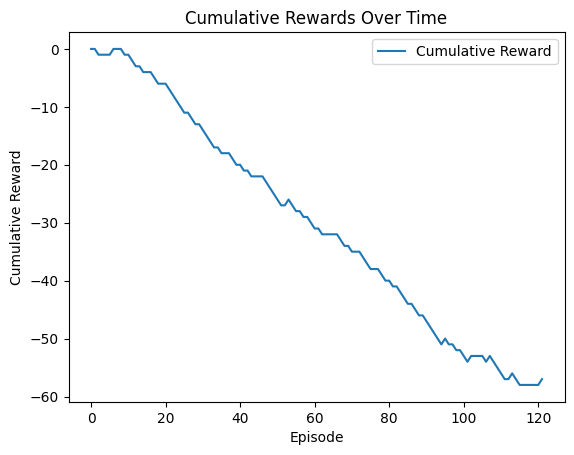

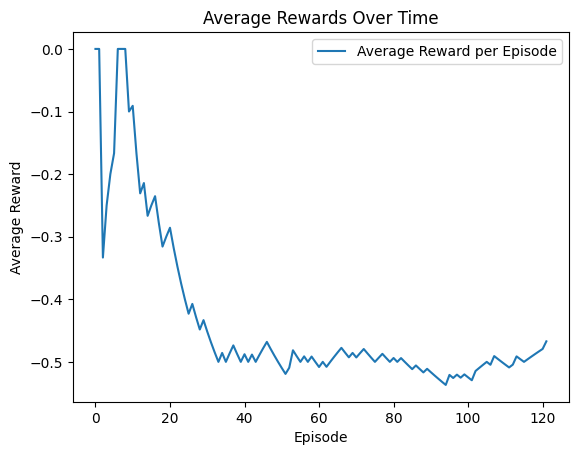

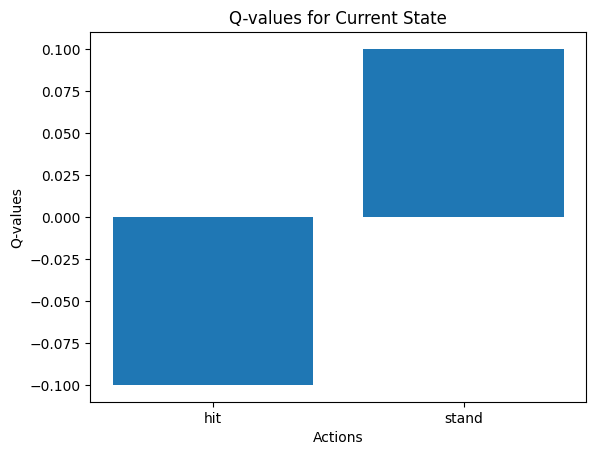

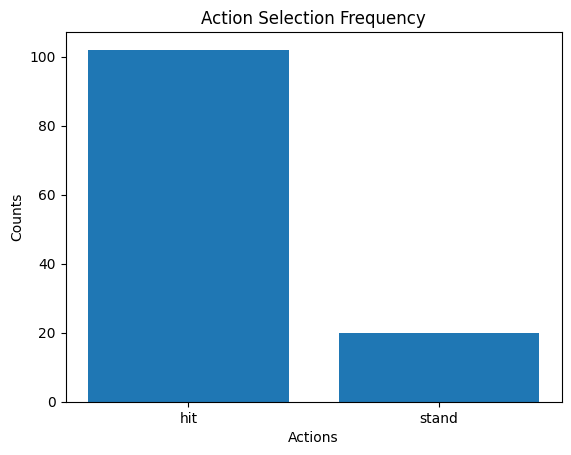

In [23]:
# Initialize environment and agent
env = BlackjackEnvironment(cnn_model=model, n_decks=8)
actions = ['hit', 'stand']
agent = QLearningAgent(state_space=None, action_space=actions)

# Create and start the GUI
root = tk.Tk()
app = BlackjackRL(
    root=root, 
    agent=agent, 
    environment=env, 
    train_episodes=1000,
    test_episodes=100,
    cnn_model_path='./models/5_model.h5', 
    rl_model_path='./models/q_learning_model.pkl'
)

app.start()

In [24]:
app.save_rl_model()

AttributeError: Can't pickle local object 'QLearningAgent.__init__.<locals>.<lambda>'